# Fake News Classifier Project

### By Phelipe Martins

In [14]:
from keras.models import Sequential
from keras.layers import LSTM
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from nltk.tokenize import word_tokenize
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import csv
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
#Evaluate model performance.
from sklearn import metrics
from html import unescape
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [15]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    

In [16]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [17]:
#import the fake news .csv
df = pd.read_csv("C:\\Users\\pheli\\Documents\\fake_or_real_news.csv")

In [18]:
'''#changing column names...
df.columns = ['id', 'title', 'content', 'type']
#set the index of the dataframe
df = df.set_index("id")
#sorting by the first column...
df = df.sort_values(by=['id'])
#prints the first lines of the dataframe'''
df.columns = ['id', 'title', 'content', 'type']
df = df.set_index("id")
df = df.sort_values(by=['id'])
df.head()

,title,content,type
id,,,
2,Study: women had to drive 4 times farther afte...,Ever since Texas laws closed about half of the...,REAL
3,"Trump, Clinton clash in dueling DC speeches","Donald Trump and Hillary Clinton, now at the s...",REAL
5,"As Reproductive Rights Hang In The Balance, De...",WASHINGTON -- Forty-three years after the Supr...,REAL
6,"Despite Constant Debate, Americans' Abortion O...",It's been a big week for abortion news.\n\nCar...,REAL
7,Obama Argues Against Goverment Shutdown Over P...,President Barack Obama said Saturday night tha...,REAL


In [19]:
df.shape

(6335, 3)

In [20]:
y = df.type

#getting the training and test sets
X_train, X_test, y_train, y_test = train_test_split(df.content, y, test_size =0.33, random_state=53)

### Some preprocessing

In [21]:
spacy.load('en')
lemmatizer = spacy.lang.en.English()

# remove html entities from docs and
# set everything to lowercase
def preprocessor(doc):
    return(unescape(doc).lower())
# tokenize the doc and lemmatize its tokens
def tokenizer(doc):
    tokens = lemmatizer(doc)
    #When I use this code the accuracy decreases
    tokens = [token for token in tokens if token.is_ascii and token.is_alpha]
    return([token.lemma_ for token in tokens])

### Using Tfidf

In [22]:
# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_df=0.7, tokenizer=tokenizer, preprocessor=preprocessor)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

In [23]:
print(tfidf_vectorizer.get_feature_names())

['-PRON-', '10', '1000', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '3', '4', '5', '50', '6', '7', '8', '9', '90', 'TRUE', 'a.m.', 'aa', 'aaa', 'aab', 'aadhar', 'aadmi', 'aae', 'aaib', 'aaj', 'aakar', 'aakhri', 'aalia', 'aaliya', 'aall', 'aam', 'aamaq', 'aamon', 'aap', 'aapke', 'aapko', 'aapne', 'aarhus', 'aaron', 'aaronson', 'aarp', 'aaso', 'aata', 'aaye', 'aayush', 'ab', 'aba', 'abaaoud', 'ababa', 'aback', 'abad', 'abadi', 'abaldo', 'aban', 'abandon', 'abandonment', 'abandonnig', 'abate', 'abatement', 'abatzoglou', 'abay', 'abayas', 'abbakumova', 'abbar', 'abbas', 'abbe', 'abbey', 'abbot', 'abbott', 'abbottabad', 'abboud', 'abbreviate', 'abbreviation', 'abby', 'abc', 'abd', 'abdallah', 'abdel', 'abdelhamid', 'abdelmoumen', 'abdeslam', 'abdicate', 'abdication', 'abdirashid', 'abdiwahab', 'abdollah', 'abdollahi', 'abdomen', 'abdominal', 'abduct', 'abductees', 'abduction', 'abductor', 'abdul', 'abdulazeez', 'abdulaziz', 'abdulghani', 'abdullah', 'abdullahuniversity

### Using Naive Bayes classifier - Tfidf

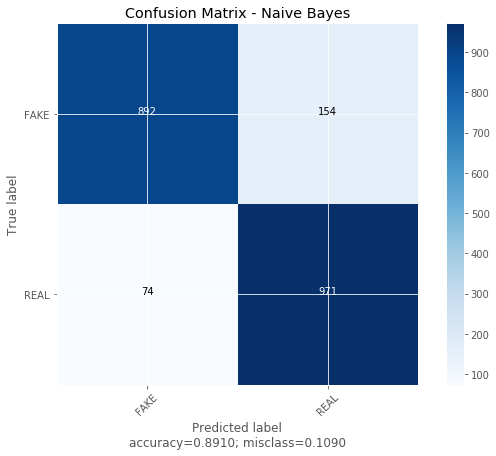

In [24]:
#best alpha = 0.1
nb_classifier = MultinomialNB(alpha=0.1)

#this will determine the internal parameters based on the dataset.
nb_classifier.fit(tfidf_train, y_train)

#this will use the trained model to predict the label based on the test data vectors.
nb_pred = nb_classifier.predict(tfidf_test)

#to further evaluate our model, we can also check the confusion matrix which shows correct
#and incorrect labels.
nb_cm = metrics.confusion_matrix(y_test, nb_pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm=nb_cm, normalize=False, target_names=['FAKE', 'REAL'], title = 'Confusion Matrix - Naive Bayes')

### Using SVM - Tfidf

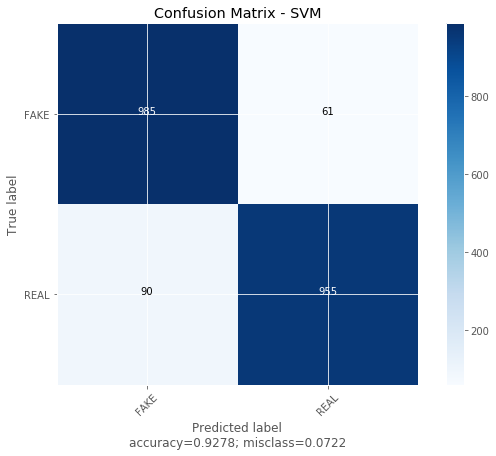

In [25]:
#best C=0.9
svm_classifier = svm.SVC(kernel ='linear', C=0.9)
svm_classifier.fit(tfidf_train, y_train)
svm_pred = svm_classifier.predict(tfidf_test)
svm_cm = metrics.confusion_matrix(y_test, svm_pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm=svm_cm, normalize=False, target_names=['FAKE', 'REAL'], title = 'Confusion Matrix - SVM')


### Using CountVectorizer (Bag-of-words)

In [ ]:
count_vectorizer = CountVectorizer(stop_words='english', max_df=0.7, tokenizer=tokenizer, preprocessor=preprocessor) #turns my text into bag-of-words vectors similar to a Gensim corpus
                                                         #it also remove english stop words from the plot summaries as a 
                                                         #preprocessing step
        
#Each token now acts as a feature for the machine learning classification problem, just like the flowers measurement in 
#the iris dataset

count_train = count_vectorizer.fit_transform(X_train) #Create the bag-of-words vectors
#fit_transform is a handy shortcut which will call the model's fit and then transform methods
#generates a mapping of words with IDs and vectors representing how many times each word appears in the plot
#Operates differently for each model, but generally fit will find parameters or norms in the data and transform 
#will apply the model's underlying algorithm or approximation
#For the CountVectorizer class, fit_transform will create the bag-of-words dictionary and vectors for each document using
#the training data

count_test = count_vectorizer.transform(X_test) #Create bag-of-words vector using the same dictionary

In [ ]:
print(count_vectorizer.get_feature_names())

### Using Naive Bayes classifier - CountVectorizer

In [ ]:
#best alpha = 0.1
nb_classifier_2 = MultinomialNB(alpha=0.1)

#this will determine the internal parameters based on the dataset.
nb_classifier_2.fit(count_train, y_train)

#this will use the trained model to predict the label based on the test data vectors.
nb_pred_2 = nb_classifier_2.predict(count_test)

#to further evaluate our model, we can also check the confusion matrix which shows correct
#and incorrect labels.
nb_cm_2 = metrics.confusion_matrix(y_test, nb_pred_2, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm=nb_cm_2, normalize=False, target_names=['FAKE', 'REAL'], title = 'Confusion Matrix - Naive Bayes - CountVectorizer')

### Using SVM - CountVectorizer

In [ ]:
#best C=0.9
svm_classifier_2 = svm.SVC(kernel ='linear', C=0.9)
svm_classifier_2.fit(count_train, y_train)
svm_pred_2 = svm_classifier_2.predict(count_test)
svm_cm_2 = metrics.confusion_matrix(y_test, svm_pred_2, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm=svm_cm_2, normalize=False, target_names=['FAKE', 'REAL'], title = 'Confusion Matrix - SVM - CountVectorizer')

### Keras

In [8]:
# integer encode
#transform y values into 0s and 1s
label_encoder = LabelEncoder()
integer_encoded_train = label_encoder.fit_transform(y_train.values)
integer_encoded_test = label_encoder.fit_transform(y_test.values)
print(integer_encoded_train)
'''
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded_train = integer_encoded_train.reshape(len(integer_encoded_train), 1)
integer_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)
onehot_encoded_train = onehot_encoder.fit_transform(integer_encoded_train)
onehot_encoded_test = onehot_encoder.fit_transform(integer_encoded_test)
print(onehot_encoded_train)
'''

[1 1 0 ... 0 1 1]


'\n# binary encode\nonehot_encoder = OneHotEncoder(sparse=False)\ninteger_encoded_train = integer_encoded_train.reshape(len(integer_encoded_train), 1)\ninteger_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)\nonehot_encoded_train = onehot_encoder.fit_transform(integer_encoded_train)\nonehot_encoded_test = onehot_encoder.fit_transform(integer_encoded_test)\nprint(onehot_encoded_train)\n'

### Word Embeddings

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

#return a list of sequences (one per text input)
X_2_train = tokenizer.texts_to_sequences(X_train)

X_2_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1 #adding 1 because of reserved 0 index

maxlen = 0
for sequence in X_2_train:
    if len(sequence) > maxlen:
        maxlen = len(sequence)


#avoid the problem that each text sequence has different length of words
X_2_train = pad_sequences(X_2_train, padding='post', maxlen=maxlen) #pads the sequence of words with zeros
X_2_test = pad_sequences(X_2_test, padding='post', maxlen=maxlen) #pads the sequence of words with zeros


### Using Convolutional Neural Network

In [14]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 21041, 100)        8004700   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 21037, 128)        64128     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 8,070,129
Trainable params: 8,070,129
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(X_2_train, integer_encoded_train,
                    epochs=3,
                    verbose=1,
                    validation_data=(X_2_test, integer_encoded_test),
                    batch_size=50) #batch_size >= 150 pc stops working


Train on 4244 samples, validate on 2091 samples
Epoch 1/5
4244/4244 [==============================] - ETA: 32:33 - loss: 0.6930 - acc: 0.54 - ETA: 29:58 - loss: 0.6946 - acc: 0.51 - ETA: 28:32 - loss: 0.6948 - acc: 0.50 - ETA: 27:22 - loss: 0.6948 - acc: 0.49 - ETA: 26:23 - loss: 0.6935 - acc: 0.52 - ETA: 25:39 - loss: 0.6930 - acc: 0.53 - ETA: 25:03 - loss: 0.6929 - acc: 0.54 - ETA: 24:34 - loss: 0.6923 - acc: 0.55 - ETA: 24:01 - loss: 0.6920 - acc: 0.55 - ETA: 23:31 - loss: 0.6919 - acc: 0.55 - ETA: 23:07 - loss: 0.6914 - acc: 0.56 - ETA: 22:49 - loss: 0.6907 - acc: 0.57 - ETA: 22:32 - loss: 0.6903 - acc: 0.57 - ETA: 22:10 - loss: 0.6895 - acc: 0.58 - ETA: 21:49 - loss: 0.6887 - acc: 0.60 - ETA: 21:28 - loss: 0.6881 - acc: 0.61 - ETA: 21:11 - loss: 0.6877 - acc: 0.61 - ETA: 20:51 - loss: 0.6870 - acc: 0.62 - ETA: 20:39 - loss: 0.6864 - acc: 0.63 - ETA: 20:22 - loss: 0.6858 - acc: 0.63 - ETA: 20:03 - loss: 0.6848 - acc: 0.64 - ETA: 19:42 - loss: 0.6839 - acc: 0.64 - ETA: 19:25 - loss

4244/4244 [==============================] - ETA: 25:57 - loss: 0.0023 - acc: 1.00 - ETA: 25:51 - loss: 0.0031 - acc: 1.00 - ETA: 25:35 - loss: 0.0031 - acc: 1.00 - ETA: 27:32 - loss: 0.0030 - acc: 1.00 - ETA: 27:14 - loss: 0.0033 - acc: 1.00 - ETA: 27:09 - loss: 0.0034 - acc: 1.00 - ETA: 27:07 - loss: 0.0035 - acc: 1.00 - ETA: 26:52 - loss: 0.0039 - acc: 1.00 - ETA: 26:37 - loss: 0.0037 - acc: 1.00 - ETA: 26:10 - loss: 0.0037 - acc: 1.00 - ETA: 25:44 - loss: 0.0036 - acc: 1.00 - ETA: 25:14 - loss: 0.0036 - acc: 1.00 - ETA: 24:38 - loss: 0.0036 - acc: 1.00 - ETA: 24:33 - loss: 0.0037 - acc: 1.00 - ETA: 24:19 - loss: 0.0038 - acc: 1.00 - ETA: 24:12 - loss: 0.0038 - acc: 1.00 - ETA: 23:58 - loss: 0.0038 - acc: 1.00 - ETA: 23:40 - loss: 0.0038 - acc: 1.00 - ETA: 23:25 - loss: 0.0038 - acc: 1.00 - ETA: 23:02 - loss: 0.0037 - acc: 1.00 - ETA: 22:34 - loss: 0.0037 - acc: 1.00 - ETA: 22:15 - loss: 0.0038 - acc: 1.00 - ETA: 22:00 - loss: 0.0038 - acc: 1.00 - ETA: 21:39 - loss: 0.0037 - acc: 1.

Training Accuracy: 1.0000
Testing Accuracy:  0.9512


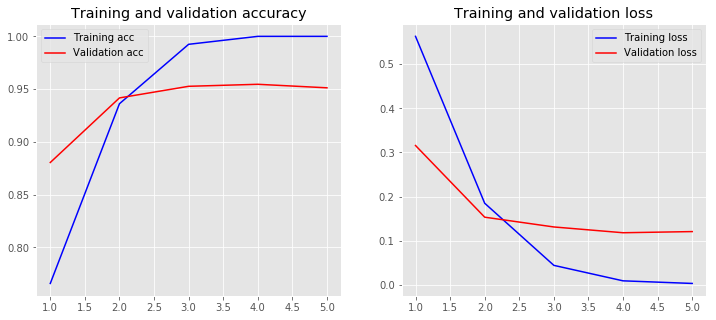

In [18]:
loss, accuracy = model.evaluate(X_2_train, integer_encoded_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_2_test, integer_encoded_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

2091/2091 [==============================] - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 56s - ETA: 51 - ETA: 45 - ETA: 40 - ETA: 35 - ETA: 30 - ETA: 25 - ETA: 19 - ETA: 14 - ETA: 9 - ETA:  - 218s 104ms/step


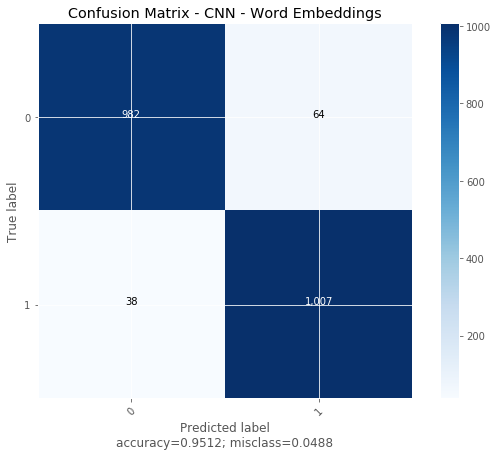

In [31]:
keras_pred = model.predict_classes(X_2_test, batch_size=50, verbose=1)
keras_cm = metrics.confusion_matrix(integer_encoded_test, keras_pred, labels=[0, 1])
plot_confusion_matrix(cm=keras_cm, normalize=False, target_names=[0, 1], title = 'Confusion Matrix - CNN - Word Embeddings')

### Using Recurrent Neural Network

In [12]:
embedding_dim2 = 100

model2 = Sequential()
model2.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim2, input_length=maxlen))
model2.add(layers.LSTM(128))
model2.add(layers.Dense(10, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 21041, 100)        8004700   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 8,123,249
Trainable params: 8,123,249
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model2.fit(X_2_train, integer_encoded_train,
                    epochs=3,
                    verbose=1,
                    validation_data=(X_2_test, integer_encoded_test),
                    batch_size=10) #batch_size >= 150 pc stops working


Train on 4244 samples, validate on 2091 samples
Epoch 1/3


1850/4244 [============>.................] - ETA: 3:55:57 - loss: 0.6932 - acc: 0.50 - ETA: 4:26:15 - loss: 0.6956 - acc: 0.35 - ETA: 4:58:52 - loss: 0.6948 - acc: 0.43 - ETA: 5:26:15 - loss: 0.6944 - acc: 0.40 - ETA: 5:55:19 - loss: 0.6941 - acc: 0.42 - ETA: 6:17:43 - loss: 0.6940 - acc: 0.41 - ETA: 6:53:02 - loss: 0.6939 - acc: 0.42 - ETA: 7:23:54 - loss: 0.6938 - acc: 0.42 - ETA: 7:48:09 - loss: 0.6937 - acc: 0.45 - ETA: 8:17:34 - loss: 0.6936 - acc: 0.48 - ETA: 8:46:29 - loss: 0.6936 - acc: 0.49 - ETA: 9:09:37 - loss: 0.6935 - acc: 0.52 - ETA: 9:32:14 - loss: 0.6935 - acc: 0.51 - ETA: 9:52:41 - loss: 0.6935 - acc: 0.52 - ETA: 10:10:35 - loss: 0.6935 - acc: 0.513 - ETA: 10:26:26 - loss: 0.6934 - acc: 0.518 - ETA: 10:41:42 - loss: 0.6934 - acc: 0.505 - ETA: 10:55:05 - loss: 0.6935 - acc: 0.494 - ETA: 11:08:59 - loss: 0.6934 - acc: 0.500 - ETA: 11:19:37 - loss: 0.6934 - acc: 0.510 - ETA: 11:28:55 - loss: 0.6934 - acc: 0.509 - ETA: 11:38:05 - loss: 0.6934 - acc: 0.504 - ETA: 11:46:53 -

In [ ]:
keras_pred2 = model2.predict_classes(X_2_test, batch_size=50, verbose=1)
keras_cm2 = metrics.confusion_matrix(integer_encoded_test, keras_pred2, labels=[0, 1])
plot_confusion_matrix(cm=keras_cm2, normalize=False, target_names=[0, 1], title = 'Confusion Matrix - RNN - Word Embeddings')